In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
#!pip install torch torchvision
#import torch
from sklearn.svm import SVC
!pip install qpsolvers
import qpsolvers
from qpsolvers import solve_qp
!pip install qpsolvers[cvxopt]
!pip install qpsolvers[open_source_solvers]
!pip install qpsolvers[clarabel]
from scipy.linalg import issymmetric

In [2]:
n_gen = 100
n_samples = 2*n_gen

In [3]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp((-1)*((np.linalg.norm(x-y))/(2*(l**2))))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp((-1)*(np.linalg.norm(x[i] - y))/(2*(l**2)))
        return vect

In [4]:
data_pos = np.random.multivariate_normal(mean=np.array((-1,-1)), cov=np.eye(2)*0.5, size=n_gen)
data_ne = np.random.multivariate_normal(mean=np.array((1.5,1.5)), cov=np.eye(2)*0.5,size=n_gen)

/tmp/ipykernel_1224/1922499333.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_1224/1922499333.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_1224/1922499333.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')
/tmp/ipykernel_1224/1922499333.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot

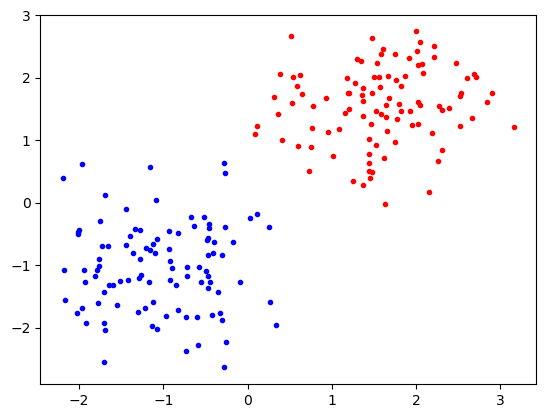

In [5]:
plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')

In [6]:
whole_data = np.vstack((data_pos,data_ne))
labels = np.hstack((np.ones(int(n_gen/4)),np.ones(n_gen)*-1,np.ones(int(3*(n_gen)/4))*-1))

In [7]:
df = pd.DataFrame(whole_data)
df.columns = ['x1','x2']
df['labels'] = labels

In [8]:
whole_space_x = np.random.uniform(low=-4,high=4,size=10000)
whole_space_y = np.random.uniform(low=-3,high=3,size=10000)

In [9]:
whole_space_x = whole_space_x.reshape(10000,1)
whole_space_y = whole_space_y.reshape(10000,1)
whole_space = np.hstack((whole_space_x,whole_space_y))

In [10]:
svm_test = SVC(kernel='sigmoid',probability=True).fit(X=df.to_numpy()[:,:2],y=df.to_numpy()[:,2])

In [11]:
probas = svm_test.predict_proba(whole_space)

/tmp/ipykernel_1224/2023409366.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_1224/2023409366.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_1224/2023409366.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')
/tmp/ipykernel_1224/2023409366.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.

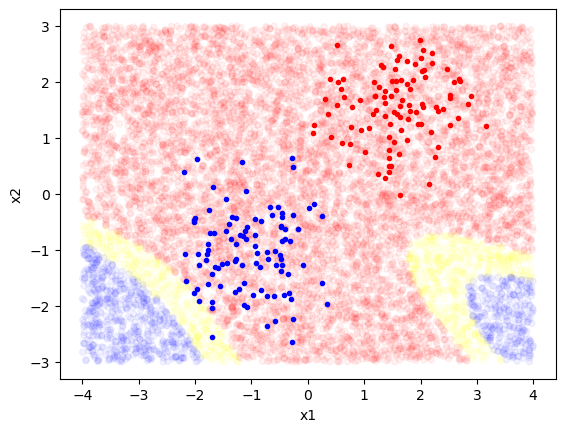

In [12]:
colors = np.empty(10000)
for i in range(10000):
    if probas[i,0]<=0.6 and probas[i,1]<=0.6:
        colors[i] = 0
    elif probas[i,0] >= probas[i,1]:
        colors[i] = 1
    else:
        colors[i] = -1

test_df = pd.DataFrame(whole_space)
test_df.columns = ['x1','x2']
test_df['colors'] = colors
colors = {0:'yellow',1:'red', -1:'blue'}
color_list = [colors[group] for group in test_df['colors']]
ax = test_df.plot.scatter('x1','x2', c=color_list,alpha=0.05)
plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')

Now that we have the probabilities, we can compute the probability gap : $\Delta \tilde{P}(X) = P(\tilde{Y} = +1 \vert X) - P(\tilde{Y} = -1 \vert X)$.

Moreover, for small datasets (as the ones in the article and the one for material science), the cross validation isn't adequate so we can use either the definition of l as $l=\inf_{y=+1} \Delta \tilde{P}(X)$ or the mean of the n' smallest values of $\Delta \tilde{P} (X)$. In the article, the value chosen for n' is n'=3.

In [13]:
probas = svm_test.predict_proba(df.to_numpy()[:,:2])

In [14]:
probas_gap = probas[:,1] - probas[:,0]

In [15]:
df['proba_gap'] = probas_gap

In [16]:
df

,x1,x2,labels,proba_gap
0,-0.586502,-2.274839,1.0,-0.657778
1,-1.268550,-1.159646,1.0,-0.684415
2,-0.259099,-2.231652,1.0,-0.734238
3,-1.342036,-0.421373,1.0,-0.818563
4,-1.121713,-0.660598,1.0,-0.792817
...,...,...,...,...
195,1.638254,1.373895,-1.0,-0.866077
196,1.752248,2.373936,-1.0,-0.947011
197,1.538964,2.228612,-1.0,-0.924110
198,0.516550,2.665280,-1.0,-0.818187


In [17]:
l_boundary = np.min(df[df['labels'] == 1]['proba_gap'].to_numpy())

In [18]:
l_boundary

-0.860232448479528

In [19]:
bayes_relab = np.zeros(df.shape[0])
df['relab'] = bayes_relab
for i in range(df.shape[0]):
    if probas_gap[i] < l_boundary:
        df.loc[i,'relab'] = -1
    elif probas_gap[i]>=0:
        df.loc[i,'relab'] = 1
    elif df.loc[i,'labels'] == 1:
        df.loc[i,'relab'] = 1

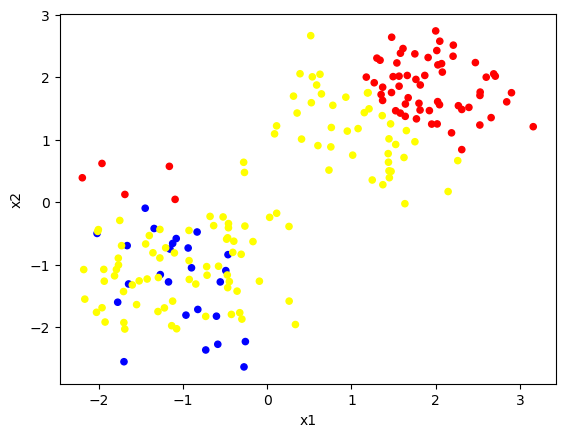

In [20]:
colors = {0:'yellow',-1:'red', 1:'blue'}
color_list = [colors[group] for group in df['relab']]
ax = df.plot.scatter('x1','x2', c=color_list)

In [21]:
df.groupby('relab').count()

,x1,x2,labels,proba_gap
relab,,,,
-1.0,63,63,63,63
0.0,112,112,112,112
1.0,25,25,25,25


In [22]:
B = 1000

In [23]:
df

,x1,x2,labels,proba_gap,relab
0,-0.586502,-2.274839,1.0,-0.657778,1.0
1,-1.268550,-1.159646,1.0,-0.684415,1.0
2,-0.259099,-2.231652,1.0,-0.734238,1.0
3,-1.342036,-0.421373,1.0,-0.818563,1.0
4,-1.121713,-0.660598,1.0,-0.792817,1.0
...,...,...,...,...,...
195,1.638254,1.373895,-1.0,-0.866077,-1.0
196,1.752248,2.373936,-1.0,-0.947011,-1.0
197,1.538964,2.228612,-1.0,-0.924110,-1.0
198,0.516550,2.665280,-1.0,-0.818187,0.0


In [24]:
labeled_data = df[df['relab'] != 0].copy()
output_labeled = labeled_data['relab'].to_numpy()
list_of_index = labeled_data.index
labeled_data = labeled_data.reset_index(drop=True)
labeled_data = labeled_data.to_numpy()[:,:2]
unlabeled_data = df.drop(index=list_of_index,axis=0)
unlabeled_data = unlabeled_data.to_numpy()[:,:2]
n_unlabeled = unlabeled_data.shape[0]
n_labels = labeled_data.shape[0]

In [25]:
capital_k = np.zeros((n_labels,n_labels))
kappa = np.zeros(n_labels)

In [26]:
#construction of capital_k
for i in range(n_labels):
    for j in range(i,n_labels):
        capital_k[i,j] = rbf(x=labeled_data[i,:],y=labeled_data[j,:])

capital_k = capital_k + capital_k.T
for i in range(n_labels):
    capital_k[i,i] = 1

capital_k[np.where(np.isnan(capital_k) == True)] = 0

#construction of kappa
ratio_lab_unlab = n_labels/n_unlabeled

for i in range(n_labels):
    vector = np.empty(n_unlabeled)
    for k in range(n_unlabeled):
        vector[k] = rbf(x=labeled_data[i,:],y=unlabeled_data[k,:])    
    kappa[i] = ratio_lab_unlab*np.sum(vector)

kappa = -kappa

In [27]:
ones_transposed = np.ones(n_labels).reshape(1,n_labels)

In [28]:
a_mat = np.vstack((ones_transposed,ones_transposed*-1,
                   np.eye(n_labels),np.eye(n_labels)*-1))

In [29]:
epsilon = (np.sqrt(n_labels)-1)/np.sqrt(n_labels)
ub_mat = np.vstack((n_labels*(1+epsilon),n_labels*(epsilon-1),
                    np.ones(n_labels).reshape(n_labels,1)*B,
                    np.zeros(n_labels).reshape(n_labels,1)))

In [30]:
beta_opti = solve_qp(P=capital_k,q=kappa,G=a_mat,h=ub_mat,solver='cvxopt')

In [32]:
svm_weighted = SVC().fit(X=labeled_data,y=output_labeled,sample_weight=beta_opti)

/tmp/ipykernel_1224/3057622047.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_1224/3057622047.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_1224/3057622047.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')
/tmp/ipykernel_1224/3057622047.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.pl

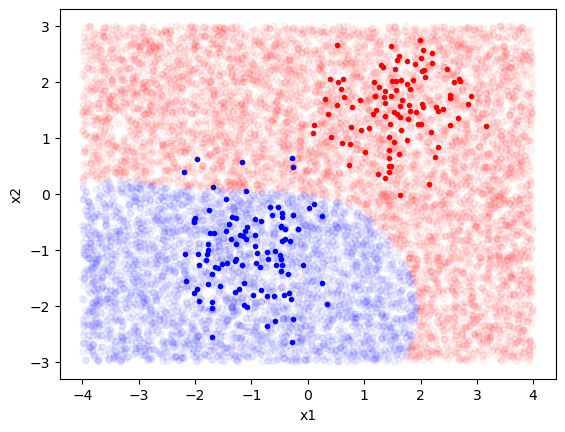

In [34]:
predictions_weighted = svm_weighted.predict(whole_space)
df_plot_weights = pd.DataFrame(whole_space)

df_plot_weights.columns = ['x1','x2']
df_plot_weights['pred'] = predictions_weighted
colors = {-1:'red', 1:'blue'}
color_list = [colors[group] for group in df_plot_weights['pred']]
ax = test_df.plot.scatter('x1','x2', c=color_list,alpha=0.05)
plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')
plt.savefig('first_pgpu_plot.png')